# Time Series Analysis with LightGBM

## Imports

In [178]:
# !pip install ucimlrepo --quiet
import pandas as pd
import numpy as np
import ucimlrepo
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb

## Load Data

In [39]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
appliances_energy_prediction = fetch_ucirepo(id=374)

# data (as pandas dataframes)
X = appliances_energy_prediction.data.features
y = appliances_energy_prediction.data.targets

In [107]:
# To Pandas DataFrame
df = pd.concat([X, y], axis=1)
df['date'] = df['date'].apply(lambda x: x[:10] + ' ' + x[11:])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 07:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
2016-01-11 07:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2016-01-11 07:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
2016-01-11 07:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
2016-01-11 07:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [108]:
# Resample to hour
df = df.resample('h').sum()
df.index.freq = 'h'

## Functions

In [164]:
class TSA:
  def __init__(self):
    pass


  def load_data(self, file_path):
    """Loads data from a CSV file and returns a Pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, index_col='Date', parse_dates=['Date'])
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None


  # Preprocess the data and engineer features
  def preprocess_data(self, df):
    """Preprocesses the data and engineers time-based features."""
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week

    # Lagged features (example: sales from previous 24 hours)
    for i in range(0, 25):
      df[f'ConsumptionLag_{i}'] = df['Appliances'].shift(i)

    # Drop rows with NaN values after lagging
    df = df.dropna()

    return df


  # Split the data into training and testing sets
  def split_data(self, df, test_size=0.2):
      """Splits the data into training and testing sets."""
      X = df.drop('Appliances', axis=1)
      y = df['Appliances']
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
      return X_train, X_test, y_train, y_test


  # Train the LightGBM model
  def train_model(self, X_train, y_train):
      """Trains a LightGBM model on the training data."""
      lgb_train = lgb.Dataset(X_train, y_train)
      lgb_eval = lgb.Dataset(X_train, y_train, reference=lgb_train)
      params = {
          'objective': 'regression',
          'metric': 'mape',
          'boosting_type': 'gbdt',
          'learning_rate': 0.05,
          'num_leaves': 31,
          'max_depth': -1,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'verbose': -1,
      }
      gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(stopping_rounds=10)])
      return gbm


  # Evaluate the model
  def evaluate_model(self, model, X_test, y_test):
      """Evaluates the model on the test data."""
      y_pred = model.predict(X_test, num_iteration=model.best_iteration)
      mape = mean_absolute_percentage_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      print(f'MAE: {mae}')
      print(f'MAPE: {mape}')
      return y_pred


  # Visualize the predictions
  def visualize_predictions(self, y_test, y_pred):
      """Visualizes the predictions against the actual values."""
      plt.figure(figsize=(19, 6))
      plt.plot(y_test.index, y_test.values, label='Actual', color='gray')
      plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.6, linewidth=2, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Consumption')
      plt.title('Consumption Prediction')
      plt.legend()
      plt.grid(True)
      plt.show()

In [165]:
tsa = TSA()

In [166]:
# Preprocess Data
prep = tsa.preprocess_data(df)

In [167]:
# Split Data
X_train, X_test, y_train, y_test = tsa.split_data(prep)

In [168]:
# Train Model
model = tsa.train_model(X_train, y_train)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's mape: 0.187642


In [169]:
# Evaluate Model
y_pred = tsa.evaluate_model(model, X_test, y_test)

MAE: 7.661289297625907
MAPE: 573592949473650.8


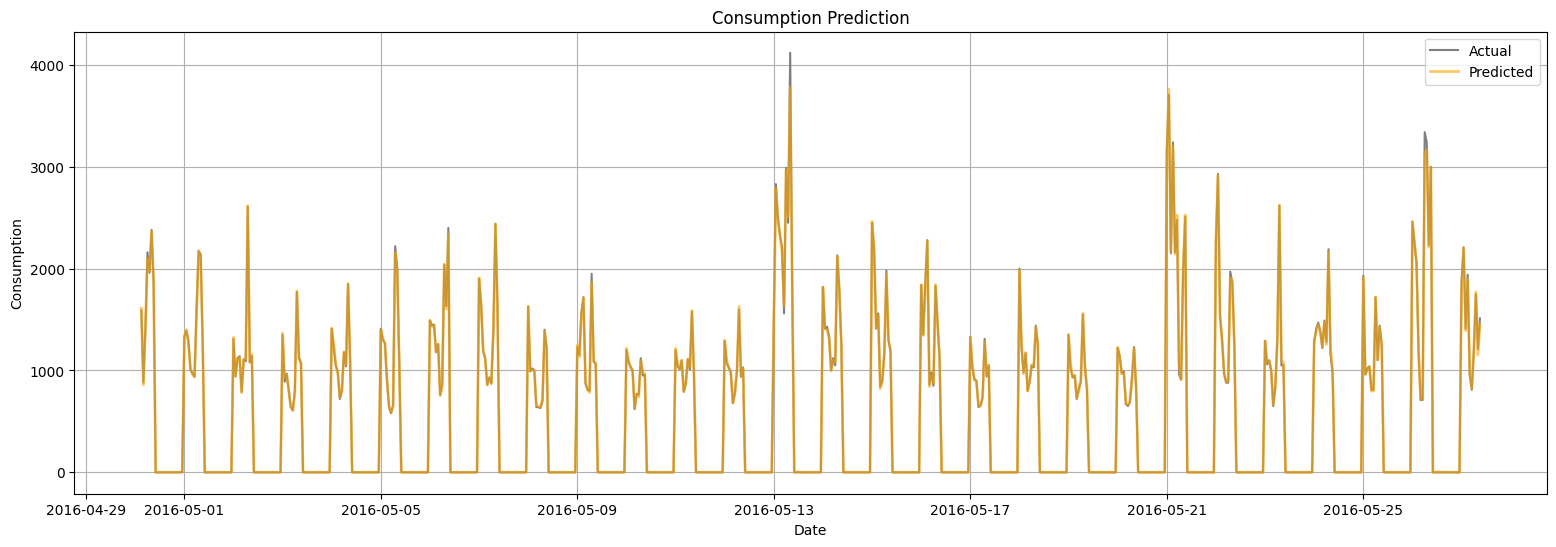

In [170]:
# Visualize
tsa.visualize_predictions(y_test, y_pred)

In [216]:
df_eval= pd.DataFrame({
    'Actual': y_test,
    'Pred': y_pred,
    'diff': y_test - y_pred,
    'mape(int%)': np.round(100*abs(y_test - y_pred)/y_test,2)
})

# Clean zeroes
df_eval['mape(int%)'] = np.select(condlist=[(df_eval['Actual'] == 0) & (df_eval['Pred']> 0.01),
                                      (df_eval['Actual'] == 0) & (df_eval['Pred']<= 0.01)],
                            choicelist= [100,0], default=df_eval['mape(int%)'])
df_eval

,Actual,Pred,diff,mape(int%)
date,,,,
2016-04-30 03:00:00,1590,1609.425292,-19.425292,1.22
2016-04-30 04:00:00,880,858.462223,21.537777,2.45
2016-04-30 05:00:00,1420,1410.448924,9.551076,0.67
2016-04-30 06:00:00,2160,2095.817736,64.182264,2.97
2016-04-30 07:00:00,1960,1983.286799,-23.286799,1.19
...,...,...,...,...
2016-05-27 05:00:00,810,821.181871,-11.181871,1.38
2016-05-27 06:00:00,1190,1199.383577,-9.383577,0.79
2016-05-27 07:00:00,1750,1770.602190,-20.602190,1.18


In [217]:
df_eval.mean()

,0
Actual,572.839695
Pred,571.337596
diff,1.502099
mape(int%),12.912733
